# 处理大量数据

- #### Cifar-10 資料集相對於常用到的影像來來說是非常⼩，所以可以先把資料集全部讀進記憶體裡⾯，要使⽤時直接從記憶體中存取，速度會相當快
- #### 但是如果我們要處理的資料集超過電腦記憶體的容量呢？桌上電腦的記憶體多為 32, 64, 128 GB，當處理超⼤圖片、3D 影像或影片時，就可能遇到 Out of Memory error
- #### 如同訓練神經網路時，Batch (批次) 的概念一樣。我們可以將資料⼀批一批的讀進記憶體，當從 GPU/CPU 訓練完後，將這批資料從記憶體釋出，再讀取下⼀批資


### 如何⽤Python 撰寫批次讀取資料的程式碼
- 使⽤ Python 的 generator 來幫你完成這個任務！
- Generator 可以使用 next(your_generator) 來執行下⼀次循環
- 假設有⼀個 list，其中有 5 個數字，我們可以撰寫一個 generator，⽤next(generator) 會⾃動吐出 list 的第一個數字，再⽤第⼆次 next 則會吐出第二個數字，以此類推
- 將原本 Python function 中的 return 改為yield，這樣 Python 就知道這是一個Generator 囉

### Generator 可以使用 next 來進行循環中的一步
文字上有點難解釋，直接來看範例就能了解什麼是 Generator!

In [1]:
# 撰寫一個 Generator，一次吐出 list 中的一個值
def output_from_list_generator(your_list):
    for i in your_list:
        yield i 

In [2]:
my_list = [1, 2, 3, 4, 5]
gen = output_from_list_generator(my_list)

In [3]:
print(next(gen))

1


In [4]:
print(next(gen))
print(next(gen))
print(next(gen))

2
3
4


In [5]:
print(next(gen))

5


In [6]:
print(next(gen))

StopIteration: 

> 從上面的範例程式碼我們可以看到，當使用一次 next，generator 就會跑 for_loop 一次，因此得到 list 中的第一個值，當再使用一次後，for_loop 記得上次的循環，所以吐出第二個值。最後一次，因為 for loop 已經執行結束了，所以再使用 next 就會看到 StopIteration，無法在得到值

In [7]:
# 我們可以撰寫一個無限循環的 Generator，只要使用 While True 即可
def inf_loop_generator(your_list):
    while True:
        for i in your_list:
            yield i

In [8]:
gen = inf_loop_generator(my_list)

In [9]:
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))
print(next(gen))

1
2
3
4
5
1
2
3


> 上面的程式碼因為我們使用了 While True，所以 for loop 不會結束，只要 call next 就一定會跑一次循環，並返回值

### 雖然 Cifar-10 的資料可以全部讀進記憶體，但讓我們試著用 Generator，批次的把 Cifar 10 的資料取出來，一次取 32 張出來！

In [10]:
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [12]:
from keras.datasets import cifar10
trainset, testset = cifar10.load_data()

Using TensorFlow backend.


In [11]:
def cifar_generator(dataset, batch_size=32):
    while True:
        for indexs in range(0, len(dataset[0]), batch_size):
            images = dataset[0][indexs: indexs+batch_size]
            labels = dataset[1][indexs: indexs+batch_size]
            yield images, labels

In [16]:
cifar_gen = cifar_generator(trainset)

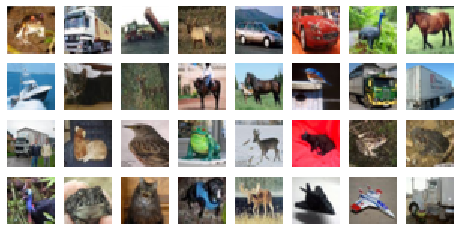

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3],
       [4],
       [7],
       [7],
       [2],
       [9],
       [9],
       [9],
       [3],
       [2],
       [6],
       [4],
       [3],
       [6],
       [6],
       [2],
       [6],
       [3],
       [5],
       [4],
       [0],
       [0],
       [9]], dtype=uint8)

In [17]:
images,labels = next(cifar_gen)
img_combine(images)
labels

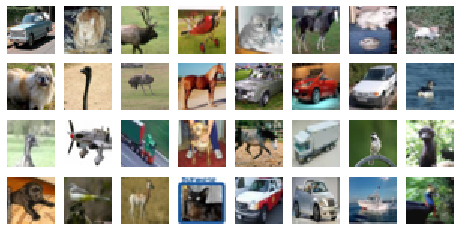

array([[1],
       [3],
       [4],
       [0],
       [3],
       [7],
       [3],
       [3],
       [5],
       [2],
       [2],
       [7],
       [1],
       [1],
       [1],
       [2],
       [2],
       [0],
       [9],
       [5],
       [7],
       [9],
       [2],
       [2],
       [5],
       [2],
       [4],
       [3],
       [1],
       [1],
       [8],
       [2]], dtype=uint8)

In [18]:
images,labels = next(cifar_gen)
img_combine(images)
labels

> 可以看到兩次的圖片並不一樣，這樣就可以開始訓練囉！

### 作業
請參考昨天的程式碼，將訓練資料讀取方式改寫成 Generator，並將原本的 model.fit 改為 model.fit_generator 來進行訓練。請參考 Keras [官方文件中 fit_generator 的說明](https://keras.io/models/sequential/)

In [19]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

In [20]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [23]:
from sklearn.utils import shuffle
def my_generator(x, y, batch_size):
    while True:
        for idx in range(0, len(x), batch_size): # 讓 idx 從 0 開始，一次增加 batch size。假設 batch_size=32, idx = 0, 32, 64, 96, ....
            batch_x, batch_y = x[idx:idx+batch_size], y[idx:idx+batch_size]
            yield batch_x, batch_y
        x, y = shuffle(x, y) # loop 結束後，將資料順序打亂再重新循環

In [24]:
train_generator = my_generator(x_train, y_train, batch_size) # 建立好我們寫好的 generator

In [25]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
390/390 [==============================] - 209s 537ms/step - loss: 1.7442 - accuracy: 0.3710 - val_loss: 1.4435 - val_accuracy: 0.4785
Epoch 2/10
390/390 [==============================] - 201s 514ms/step - loss: 1.3309 - accuracy: 0.5268 - val_loss: 1.2348 - val_accuracy: 0.5595
Epoch 3/10
390/390 [==============================] - 171s 439ms/step - loss: 1.1183 - accuracy: 0.6089 - val_loss: 0.9778 - val_accuracy: 0.6589
Epoch 4/10
390/390 [==============================] - 170s 436ms/step - loss: 0.9749 - accuracy: 0.6597 - val_loss: 0.9106 - val_accuracy: 0.6806
Epoch 5/10
390/390 [==============================] - 170s 435ms/step - loss: 0.8853 - accuracy: 0.6914 - val_loss: 0.8342 - val_accuracy: 0.7128
Epoch 6/10
390/390 [==============================] - 170s 435ms/step - loss: 0.8148 - accuracy: 0.7174 - val_loss: 0.7685 - val_accuracy: 0.7342
Epoch 7/10
390/390 [==============================] - 170s 436ms/step - loss: 0.7575 - accuracy: 0.7352 - val_loss: 0.7592 -

# 处理小量数据
## 資料增強 (Data augmentation) 是很常見的⽅法之一
> 對影像進行⼀些隨機的處理如翻轉、平移、旋轉、改變亮度等各樣的影像操作，藉此將⼀張影像增加到多張
<img src="imgs/keras18_1.png" width="100%">

#### 適度的資料增強通常都可以提升準確率。
- 選⽤的增強⽅法則須視資料集⽽定
- 例如⼈臉辨識就不太適合⽤上下翻轉，因為實際使用時不會有上下顛倒的臉部
- 另外需特別注意要先對資料做 train/test split 後再做資料增強！否則其實都是同樣的影像，誤以為模型訓練得非常好

[图片数据集太少？看我七十二变，Keras Image Data Augmentation 各参数详解](https://zhuanlan.zhihu.com/p/30197320)

[套件：imgaug](https://github.com/aleju/imgaug)

In [2]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [3]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [4]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

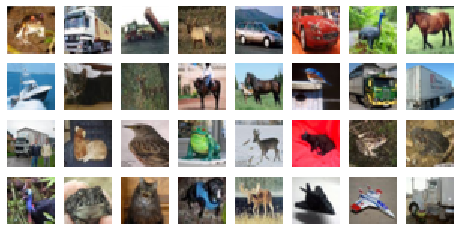

In [5]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [6]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

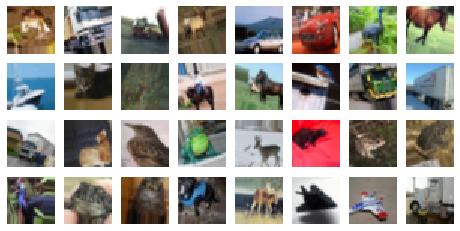

In [7]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。
# (shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

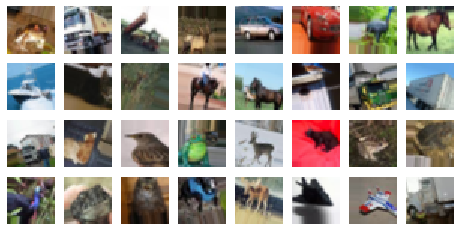

In [8]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業
> 請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [9]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam

In [10]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [13]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [14]:
history = model.fit_generator(data_generator.flow(x_train,y_train, batch_size, shuffle=True),
                    steps_per_epoch=int(len(x_train)/batch_size), # 一個 epochs 要執行幾次 update，通常是資料量除以 batch size
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
390/390 [==============================] - 222s 570ms/step - loss: 1.9342 - accuracy: 0.2876 - val_loss: 1.5590 - val_accuracy: 0.4342
Epoch 2/10
390/390 [==============================] - 200s 513ms/step - loss: 1.6042 - accuracy: 0.4174 - val_loss: 1.3379 - val_accuracy: 0.5137
Epoch 3/10
390/390 [==============================] - 193s 495ms/step - loss: 1.4562 - accuracy: 0.4747 - val_loss: 1.5442 - val_accuracy: 0.4816
Epoch 4/10
390/390 [==============================] - 192s 493ms/step - loss: 1.3617 - accuracy: 0.5125 - val_loss: 1.2103 - val_accuracy: 0.5677
Epoch 5/10
390/390 [==============================] - 194s 497ms/step - loss: 1.2947 - accuracy: 0.5382 - val_loss: 1.0291 - val_accuracy: 0.6345
Epoch 6/10
390/390 [==============================] - 193s 494ms/step - loss: 1.2390 - accuracy: 0.5606 - val_loss: 1.0308 - val_accuracy: 0.6325
Epoch 7/10
390/390 [==============================] - 231s 592ms/step - loss: 1.2046 - accuracy: 0.5752 - val_loss: 1.0334 -

# Transfer learning 
- 资料量不足时，迁移学习是很常见的方法
- 神经网路训练前的初始参数是随机产生的，不具备任何意义
- 透过在其它庞大资料集上训练好的模型参数，我们使用这个参数当作起始点，改用在自己的资料集上训练。
 
> Keras中的模型，只要指定权重(weights="imagenet")即可使用迁移学习

## [Keras 以 ResNet-50 預訓練模型建立狗與貓辨識程式](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)

In [48]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [70]:
from keras.datasets import cifar10
import resnet_builder
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

In [71]:
# 建立 ResNet 模型
from imp import reload
reload(resnet_builder)
model = resnet(input_shape=(32,32,3)) 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 16)   64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 32, 32, 16)   0           batch_normalization_v1[0][0]     
____________________________________________________________________________________________

[module ‘tensorflow’ has no attribute ‘get_default_graph’](https://blog.csdn.net/u014466109/article/details/88877321)

> pip uninstall tensorflow # 卸载tf

> pip uninstall keras # 卸载keras

> pip install tensorflow==1.2.0

> pip install keras==2.0.9

In [72]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30 # 訓練整個資料集共 30個循環

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3939s 79ms/sample - loss: 1.8120 - acc: 0.5186 - val_loss: 4.8548 - val_acc: 0.2295
Epoch 2/30
16000/50000 [========>.....................] - ETA: 3:26:26 - loss: 1.3826 - acc: 0.6492

KeyboardInterrupt: 

### [Discover the current state of the art in objects classification.](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)

### [Keras 以 ResNet-50 預訓練模型建立狗與貓辨識程式](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)

In [59]:
# 使用的 Keras 是 TensorFlow 1.8.0 所內建的版本
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [61]:
# 資料路徑
DATASET_PATH  = 'sample'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 2

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS = 20

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Class #0 = cats
Class #1 = dogs


C:\Users\qishi shi\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 89s 1us/step


W1220 16:59:56.367719 265232 deprecation.py:506] From C:\Users\qishi shi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

Epoch 1/20
400/400 [==============================] - 18320s 46s/step - loss: 0.8004 - acc: 0.7513 - val_loss: 0.2070 - val_acc: 0.9388
Epoch 2/20
400/400 [==============================] - 5516s 14s/step - loss: 0.3896 - acc: 0.8844 - val_loss: 0.1920 - val_acc: 0.9525
Epoch 3/20
400/400 [==============================] - 48211s 121s/step - loss: 0.3442 - acc: 0.9084 - val_loss: 0.1253 - val_acc: 0.9625
Epoch 4/20
301/400 [=====================>........] - ETA: 1:14:16 - loss: 0.2462 - acc: 0.9286

KeyboardInterrupt: 